#Pipeline to compute metrics from our Unet model with attention Gates.
Here we'll be using a Unet model with 5 blocks and pair of images (post and pre) as inputs.

##Useful imports

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
#import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
from tqdm.contrib.telegram import tqdm, trange
from torchvision.io import read_image
import torchvision.transforms.functional as transform
from torchvision.transforms.transforms import Resize
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import random
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.autograd import Variable
import datetime, os
import torchvision.transforms.functional as TF
import torchvision


##Gdrive import + PATHS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
IMG_PATH_TEST = '/content/drive/My Drive/natural_catastroph_folder/testing_dataset/images'
MASK_PATH_TEST = '/content/drive/My Drive/natural_catastroph_folder/testing_dataset/targets'

CSV_PATH = '/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/notebooks/csv_generated_by_luka/dataset1_csv_test.csv'


In [ ]:
#Path to compute the classification ONLY metrics
#Thats where we take the polygons of each building and give it a label from our generated masks
CSV_PATH1_TEST = '/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/notebooks/csv_generated_by_luka/dataset1_csv_test.csv'
CSV_PATH2_TEST = '/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/notebooks/csv_generated_by_luka/dataset2_csv_test.csv'
CSV_PATH3_TEST = '/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/notebooks/csv_generated_by_luka/dataset3_csv_test.csv'

JSON_PATH = '/content/drive/My Drive/natural_catastroph_folder/training_dataset/labels'

##Our Unet model

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

    def psi_mask(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

    def first_attentionGate_mask(self, x):
      # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        psi = self.Att2.psi_mask(g=d2,x=x1)

        return psi

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
"""HERE ONLY 3 CHANNELS NOT 5 BECAUSE WE MERGED SOME CLASSES"""
model = AttU_Net(img_ch=6, output_ch=3).to(device)


#name_save_model = "duo-AttUnet_512px_3classes"
name_save_model = "duo-AttUnet_dataset1_512px_3classes"

path_model = F"/content/drive/My Drive/natural_catastroph_folder/Yanis_folder/saved_models/{name_save_model}"
model.load_state_dict(torch.load(path_model))

<All keys matched successfully>

##Datasets + Dataloaders

In [ ]:
#Dataset TO DISPLAY IMAGES AND GENERATED MASK
class ImageDatasetDuoCSV_DISPLAY(Dataset):
  def __init__(self,img_folder, mask_folder,csv_path,transform=None, transform_mask=None, std_mean=None):
    self.transform=transform
    self.transform_mask=transform_mask
    self.std_mean=std_mean

    self.img_folder=img_folder
    self.mask_folder=mask_folder

    self.csv_file = pd.read_csv(csv_path)
  
#The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,index):
    img_pre_name = self.csv_file['img_pre'].iloc[index]
    mask_pre_name = self.csv_file['mask_pre'].iloc[index]
    img_post_name = self.csv_file['img_post'].iloc[index]
    mask_post_name = self.csv_file['mask_post'].iloc[index]

    img_pre = read_image(self.img_folder+'/'+img_pre_name).type(torch.FloatTensor)
    img_post = read_image(self.img_folder+'/'+img_post_name).type(torch.FloatTensor)

    #mask_pre = read_image(self.mask_folder+'/'+mask_pre_name).type(torch.LongTensor)
    mask_post = read_image(self.mask_folder+'/'+mask_post_name).type(torch.LongTensor)

    """
    IF WE WANT TO HAVE ONLY 3 CLASSES --> Background(0), No-damage(1) and Damage(2)
    DONT FORGET TO CHANGE THE NUMBER OF CHANNELS IN THE MODEL
    """

    mask_post[mask_post==2] = 1
    mask_post[mask_post==3] = 2
    mask_post[mask_post==4] = 2

    #MANUAL TRANSFORMS:
    if self.std_mean != None:
      normalize = transforms.Normalize(mean=std_mean[1], std=std_mean[0])
    else: 
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img_pre = normalize(img_pre)
    img_post_normalized = normalize(img_post)

    resize = transforms.Resize(size=(512, 512))

    img_pre = resize(img_pre)
    img_post_normalized = resize(img_post_normalized)
    img_post = resize(img_post)

    #mask_pre = resize(mask_pre)
    mask_post = resize(mask_post)

    image = torch.concat((img_pre, img_post_normalized), 0)
    #mask = torch.concat((mask_pre, mask_post), 0)
    mask = mask_post


    return img_post, image, mask


In [ ]:
def split_dataset(dataset, ratio):
    length1 = int(len(dataset) * ratio)
    length2 = len(dataset) - length1
    lengths = [length1, length2]
    return random_split(dataset, lengths)

In [ ]:
dataset_display = ImageDatasetDuoCSV_DISPLAY(IMG_PATH_TEST, MASK_PATH_TEST, CSV_PATH)
#train_dataset, dataset_display = split_dataset(dataset, 0.7)


print(f"Length of display dataset: {len(dataset_display):,}")

Length of display dataset: 632


In [ ]:
BATCH_SIZE = 4
display_dataloader = DataLoader(dataset_display, batch_size=1, shuffle=True)  #We want to display only one images for the moment

##Display our satellite image and our 1st attendtion gate layer 

In [ ]:
#Generate ONE time image + mask + psi
model.eval()
with torch.no_grad():
  image_post, image, mask = next(iter(display_dataloader))

  image, mask = image.to(device), mask.to(device)
  psi = model.first_attentionGate_mask(image)
  print(psi.size()) 

  predictions = model(image) 
  predictions = torch.nn.functional.softmax(predictions, dim=1)

  pred_labels = torch.argmax(predictions, dim=1) 
  pred_labels = pred_labels.int()


santa-rosa-wildfire_00000375_pre_disaster.png
torch.Size([1, 1, 512, 512])


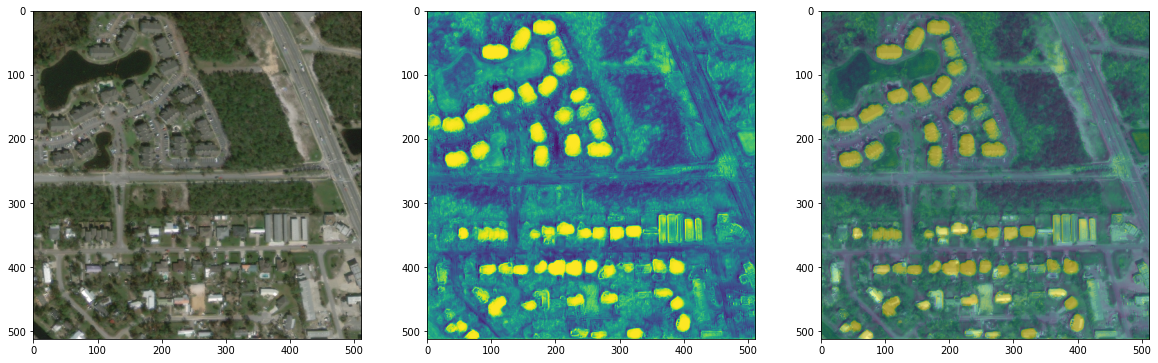

In [ ]:
#Display Image + Where is the ATTENTION of the model
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1,3)

axarr[0].imshow(image_post[0].permute(1,2,0)/255)
axarr[1].imshow(psi[0].detach().cpu().squeeze())

axarr[2].imshow(image_post[0].permute(1,2,0)/255)
axarr[2].imshow(psi[0].detach().cpu().squeeze(), alpha=0.5)


(512, 512)
(512, 512, 4)


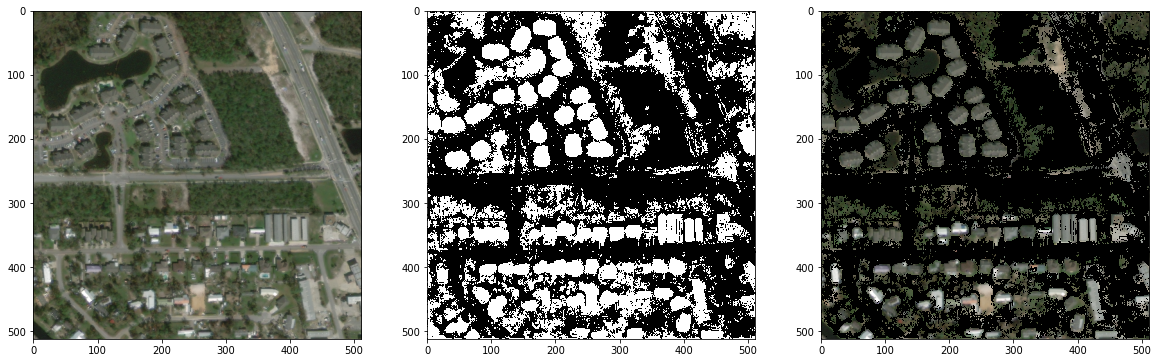

In [ ]:
#Display Image + Where is the ATTENTION of the model
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1,3)

axarr[0].imshow(image_post[0].permute(1,2,0)/255)

# G is a NxNx3 matrix
G = np.zeros((512, 512, 4))

# Where we set the RGB for each pixel
Z = psi[0].detach().cpu().squeeze().numpy()
print(Z.shape)
print(G.shape)

G[Z>0.5] = [1,1,1,0]
G[Z<0.5] = [0,0,0, 1]


axarr[1].imshow(G, interpolation='nearest')

axarr[2].imshow(image_post[0].permute(1,2,0)/255)
axarr[2].imshow(G, alpha=1, interpolation='nearest')


##Compute our Test confusion Matrix + recall-precision-f1 metrics

In [ ]:
BATCH_SIZE = 16
display_dataloader = DataLoader(dataset_display, batch_size=BATCH_SIZE, shuffle=True) 

MetricBar: 100%|██████████| 40/40 [15:08<00:00, 22.70s/it]


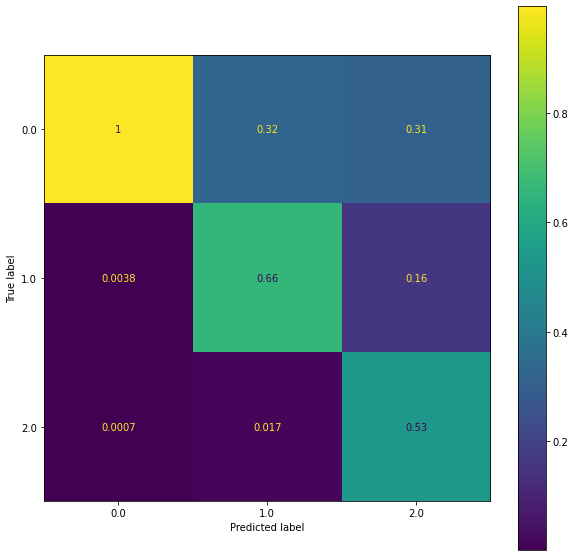

In [ ]:
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

#Confusion Matrix for ALL THE DATASET
mask_all = np.array([])
pred_labels_all = np.array([])

model.eval()
with torch.no_grad():
  metric_bar = tqdm(display_dataloader, total=len(display_dataloader), desc="MetricBar", position=0, leave=True)

  for image_post, image, mask in metric_bar:

    image, mask = image.to(device), mask.to(device)

    predictions = model(image) 
    predictions = torch.nn.functional.softmax(predictions, dim=1)

    pred_labels = torch.argmax(predictions, dim=1) 
    pred_labels = pred_labels.int()

    mask_all = np.concatenate((mask_all, torch.flatten(mask).cpu().numpy()), axis=0) 
    pred_labels_all = np.concatenate((pred_labels_all, torch.flatten(pred_labels).cpu().numpy()), axis=0) 


plt.rcParams["figure.figsize"] = (10,10)

#We normalize the count display over the predicted conditions
ConfusionMatrixDisplay.from_predictions(mask_all, pred_labels_all, normalize='pred')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(mask_all, pred_labels_all, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98 155955549
           1       0.66      0.91      0.76   8680967
           2       0.53      0.70      0.60   1038492

    accuracy                           0.97 165675008
   macro avg       0.73      0.86      0.78 165675008
weighted avg       0.97      0.97      0.97 165675008



## Compute classification ONLY metrics 
Thats where we take the polygons of each buildings and compare them to our generated masks

###Dataset + Dataloader

In [9]:
#Dataset evaluate ONLY the CLASSIFICATION part
class ImageDatasetDuoCSV_EVALUATE(Dataset):
  def __init__(self,img_folder, mask_folder,csv_path,transform=None, transform_mask=None, std_mean=None):
    self.transform=transform
    self.transform_mask=transform_mask
    self.std_mean=std_mean

    self.img_folder=img_folder
    self.mask_folder=mask_folder

    self.csv_file = pd.read_csv(csv_path)
  
#The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,index):
    img_pre_name = self.csv_file['img_pre'].iloc[index]
    img_post_name = self.csv_file['img_post'].iloc[index]

    img_pre = read_image(self.img_folder+'/'+img_pre_name).type(torch.FloatTensor)
    img_post = read_image(self.img_folder+'/'+img_post_name).type(torch.FloatTensor)


    """
    IF WE WANT TO HAVE ONLY 3 CLASSES --> Background(0), No-damage(1) and Damage(2)
    DONT FORGET TO CHANGE THE NUMBER OF CHANNELS IN THE MODEL
    """


    #MANUAL TRANSFORMS:
    if self.std_mean != None:
      normalize = transforms.Normalize(mean=std_mean[1], std=std_mean[0])
    else: 
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img_pre = normalize(img_pre)
    img_post_normalized = normalize(img_post)


    image = torch.concat((img_pre, img_post_normalized), 0)


    path_post = self.img_folder+'/'+img_post_name

    return image, path_post


In [10]:
dataset_evaluate = ImageDatasetDuoCSV_EVALUATE(IMG_PATH_TEST, MASK_PATH_TEST, CSV_PATH1_TEST)


In [11]:
BATCH_SIZE = 4
evaluate_dataloader = DataLoader(dataset_evaluate, batch_size=BATCH_SIZE, shuffle=True) 

###We generate the masks

In [ ]:
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

pred_labels_all = []
image_path_all = []

model.eval()
with torch.no_grad():
  metric_bar = tqdm(evaluate_dataloader, total=len(evaluate_dataloader), desc="MetricBar", position=0, leave=True)

  for image, image_path in metric_bar:

    image = image.to(device)

    predictions = model(image) 
    predictions = torch.nn.functional.softmax(predictions, dim=1)

    pred_labels = torch.argmax(predictions, dim=1) 
    pred_labels = pred_labels.int()

    pred_labels_all.append(pred_labels.cpu().numpy()) 

    image_path_all.append(image_path) 


MetricBar: 100%|██████████| 43/43 [00:35<00:00,  1.20it/s]


In [ ]:
pred_labels_all = [e for sl in pred_labels_all for e in sl]
image_path_all = [e for sl in image_path_all for e in sl]


### We compute our classification metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import shapely.wkt
import json
import cv2
import matplotlib.path as mpltPath
def getArrayFromCrop(feat, damage):

    try:
        damage_type = feat['properties']['subtype']
    except: # pre-disaster damage is default no-damage
        damage_type = "no-damage"
        return
    polygon_geom= shapely.wkt.loads(feat['wkt'])
    polygon_pts = np.array(list(polygon_geom.exterior.coords))
    # 
    
    width, height=1024, 1024
    #print(polygon_pts.shape)
    poly_path=mpltPath.Path(polygon_pts)
    x, y = np.mgrid[:height, :width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    mask = poly_path.contains_points(coors).reshape(height, width).T

    img_masked=np.zeros(mask_array.shape,dtype=mask_array.dtype)
    #print(img_masked.shape)
    #print(mask_array.shape)
    img_masked[mask]=mask_array[mask]
    
    values, counts = np.unique(img_masked[img_masked != 0], return_counts=True)
    #print(values)

    if len(counts) == 0:
      #print('Count error')
      return (None, None)
    ind = np.argmax(counts)
    majority = values[ind]
    
    #For our testing pipeline only 2 classes no-damage and damage
    damage_dict = {
        "no-damage": 1,
        "minor-damage": 1,
        "major-damage": 2,
        "destroyed": 2
    }
    """
    damage_dict = {
        "no-damage": 1,
        "minor-damage": 2,
        "major-damage": 3,
        "destroyed": 4,
        "un-classified": 5
    }
    """
    damage_type = damage['properties']['subtype']

    if damage_type == "un-classified":
      return (None, None)

    #Return (ground truth, prediction)
    return (damage_dict[damage_type], majority)

    """
    #True --> right classe, False-- > Wrong class
    if damage_dict[damage_type] == majority:
        return {damage_dict[damage_type]: majority}
    else:
        return False
    """

In [ ]:
ground_truth_list = []
prediction_list = []

for pred_label, image_path in zip(pred_labels_all, image_path_all):

  json_path = image_path.replace('.png', '.json').replace('images', 'labels')
  #print(json_path)
  #break
  try:
    label_file = open(json_path)
  except FileNotFoundError:
    print("FileNotFoundError")
    continue

  label_data = json.load(label_file)

  mask_array = pred_label


  #For ONE JSON FILE
  #print(mask_path)
  for feat, damage in zip(label_data['features']['xy'], label_data['features']['lng_lat']):
    ground_truth, prediction = getArrayFromCrop(feat, damage)
    ground_truth_list.append(ground_truth)
    prediction_list.append(prediction)


In [ ]:
from sklearn.metrics import classification_report

ground_truth_list = [x for x in ground_truth_list if x is not None]
prediction_list = [x for x in prediction_list if x is not None]
print(classification_report(ground_truth_list, prediction_list, labels = [1,2]))

              precision    recall  f1-score   support

           1       0.91      0.92      0.92      6840
           2       0.58      0.54      0.56      1352

    accuracy                           0.86      8192
   macro avg       0.74      0.73      0.74      8192
weighted avg       0.86      0.86      0.86      8192



###Display json polygons over the generated mask

In [12]:
pip install rasterio --quiet

In [13]:
from PIL import Image, ImageDraw
import rasterio.features
import shapely.geometry
import numpy as np
import rasterio
from rasterio.plot import show

#Tweaked code from the Xview2 challenge github
def save_img(path_to_image, path_to_localization, path_to_damage, path_to_output, pred_labels): 
    no_damage_polygons = []
    minor_damage_polygons = []
    major_damage_polygons = []
    destroyed_polygons = []

    # Load the challenge output localization image
    localization = Image.open(path_to_localization)
    
    loc_arr = np.array(localization)

    # If the localization has damage values convert all non-zero to 1
    # This helps us find where buildings are, and then use the damage file
    # to get the value of the classified damage
    loc_arr = (loc_arr >= 1).astype(np.uint8)

    # Load the challenge output damage image
    #damage = Image.open(path_to_damage)
    transform = T.ToPILImage()
    damage = transform(pred_labels)

    dmg_arr = np.array(damage)

    # Use the localization to get damage only were they have detected buildings
    mask_arr = dmg_arr*loc_arr
    
    # Get the value of each index put into a dictionary like structure
    shapes = rasterio.features.shapes(mask_arr)
    
    # Iterate through the unique values of the shape files 
    # This is a destructive iterator or else we'd use the pythonic for x in shapes if x blah 
    for shape in shapes:
        if shape[1] == 1:
            no_damage_polygons.append(shapely.geometry.Polygon(shape[0]["coordinates"][0]))
        elif shape[1] == 2:
            minor_damage_polygons.append(shapely.geometry.Polygon(shape[0]["coordinates"][0]))
        elif shape[1] == 3:
            major_damage_polygons.append(shapely.geometry.Polygon(shape[0]["coordinates"][0]))
        elif shape[1] == 4:
            destroyed_polygons.append(shapely.geometry.Polygon(shape[0]["coordinates"][0]))
        elif shape[1] == 0:
            continue
        else:
            print("Found non-conforming damage type: {}".format(shape[1]))
    
    # Loading post image
    #img = Image.open(path_to_image) 
    img = Image.open(path_to_localization).convert('RGB') 
    
    
    draw = ImageDraw.Draw(img, 'RGBA')
    #draw = ImageDraw.Draw(img)
    
    damage_dict = {
        "no-damage": (0, 255, 0, 100),
        "minor-damage": (0, 0, 255, 125),
        "major-damage": (255, 69, 0, 125),
        "destroyed": (255, 0, 0, 125),
        "un-classified": (255, 255, 255, 125)
    }
    
    # Go through each list and write it to the post image we just loaded
    for polygon in no_damage_polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict["no-damage"])

    for polygon in minor_damage_polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict["minor-damage"])

    for polygon in major_damage_polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict["major-damage"])

    for polygon in destroyed_polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict["destroyed"])
    
    plt.imshow(img.convert("L"))
    #img.save(path_to_output)

In [14]:
displayJson_dataloader = DataLoader(dataset_evaluate, batch_size=1, shuffle=True) 

model.eval()
image, image_path = next(iter(displayJson_dataloader))
print(image_path)

('/content/drive/My Drive/natural_catastroph_folder/testing_dataset/images/hurricane-michael_00000168_post_disaster.png',)


In [15]:
image = image.to(device)

predictions = model(image) 
predictions = torch.nn.functional.softmax(predictions, dim=1)

pred_labels = torch.argmax(predictions, dim=1) 
pred_labels = pred_labels.int()


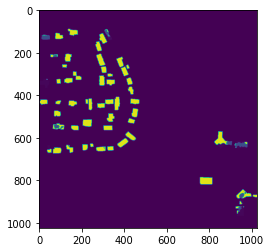

In [16]:
import torchvision.transforms as T
import PIL

image_path = IMG_PATH_TEST + "/hurricane-michael_00000168_pre_disaster.png"
mask_path = MASK_PATH_TEST + '/hurricane-michael_00000168_post_disaster_target.png'

save_img(image_path, mask_path, mask_path, '-----', pred_labels.cpu())

##Code to fix CUDA ERRORS

In [13]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()